In [93]:
from funciones_helmholtz_bem import Circle_n
from funciones_helmholtz_bem import frequencyToWavenumber
from funciones_helmholtz_bem import solveExteriorBoundary
from funciones_helmholtz_bem import solveExterior
from funciones_helmholtz_bem import phi_test_problem_1_2
from funciones_helmholtz_bem import generateInteriorPoints_test_problem_2
from funciones_helmholtz_bem import plot_solutions
from funciones_helmholtz_bem import plot_edges_and_field
from funciones_helmholtz_bem import generateInteriorPoints_excluding_circle
from funciones_helmholtz_bem import sound_hard_circle_calc
from funciones_helmholtz_bem import mask_displacement
from funciones_helmholtz_bem import plot_exact_displacement
from funciones_helmholtz_bem import plot_bem_displacements
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from numpy.linalg import norm
# reload kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
# Simulación de dispersión por obstáculo circular rígido
k = 3.0
n = 30

# Crear malla circular con centro en el origen
aVertex, aElement = Circle_n(n=n, radius=np.pi/4)
size = aElement.shape[0]

# Condición Neumann homogénea: sound-hard obstacle
alpha = np.full(size, 0.0, dtype=complex)
beta  = np.full(size, 1.0, dtype=complex)
f     = np.empty(size, dtype=complex)
phi   = np.full(size, 0.0, dtype=complex)
v     = np.full(size, 0.0, dtype=complex)

# Centro de cada elemento
aCenters = 0.5 * (aVertex[aElement[:, 0]] + aVertex[aElement[:, 1]])

# Vectores tangentes y normales exteriores
theta = np.atan2(aCenters[:, 1], aCenters[:, 0])
 
# Evaluación de la onda incidente en los centros: φ_inc = exp(i k x)
kx = k * aCenters[:, 0]  # x es la primera componente
phi_inc = np.exp(1j * kx)

# Derivada normal: dφ_inc/dn = i k * exp(i k x) * n_x
f[:] = np.cos(theta) * -1j * k * phi_inc #  n_x es la componente x de la normal

# Generar puntos en el dominio rectangular excluyendo un círculo
n_dom = 100
points_outside, points_inside = generateInteriorPoints_excluding_circle(
    Nx=n_dom, Ny=n_dom,
    xmin=-np.pi, xmax=np.pi,
    ymin=-np.pi, ymax=np.pi,
    r_exclude=np.pi / 4
)

# Generar puntos en el dominio rectangular dentro de un círculo
c, density = None, None  # 
v, phi = solveExteriorBoundary(
    k, alpha, beta, f, phi, v,
    aVertex, aElement,
    c, density,
    'exterior'
)

In [102]:

def generateRectangleBoundaryPoints(Nx=20, Ny=20,
                                    xmin=-2.0, xmax=2.0,
                                    ymin=-2.0, ymax=2.0):
    # Coordenadas constantes para cada lado
    x_left   = np.full(Ny, xmin)
    x_right  = np.full(Ny, xmax)
    y_bottom = np.full(Nx, ymin)
    y_top    = np.full(Nx, ymax)

    # Puntos uniformemente distribuidos en cada lado
    y_vals = np.linspace(ymin, ymax, Ny)
    x_vals = np.linspace(xmin, xmax, Nx)

    # Puntos sobre cada borde
    left   = np.column_stack((x_left, y_vals))    # borde izquierdo
    right  = np.column_stack((x_right, y_vals))   # borde derecho
    bottom = np.column_stack((x_vals, y_bottom))  # borde inferior
    top    = np.column_stack((x_vals, y_top))     # borde superior

    # Unir todos los puntos de los bordes
    all_edges = np.vstack((left, right, bottom, top))

    # Eliminar duplicados en las esquinas (opcional pero recomendable)
    all_edges = np.unique(all_edges, axis=0)

    return all_edges.astype(np.float32)


In [103]:
points_outside = generateRectangleBoundaryPoints(Nx=20, Ny=20)

In [104]:
# Inicializar el potencial incidente en los puntos exteriores como cero
interiorIncidentPhi = np.zeros(points_outside.shape[0], dtype=complex)

In [105]:
c, density = None, None  # Se puede cambiar si se tienen valores iniciales
v, phi = solveExteriorBoundary(
    k, alpha, beta, f, phi, v,
    aVertex, aElement,
    c, density,
    'exterior'
)

In [106]:
# Evaluar el potencial numérico en los puntos del dominio exterior
interiorPhi = solveExterior(
    k, v, phi,
    interiorIncidentPhi,
    points_outside,
    aVertex, aElement,
    'exterior'
)

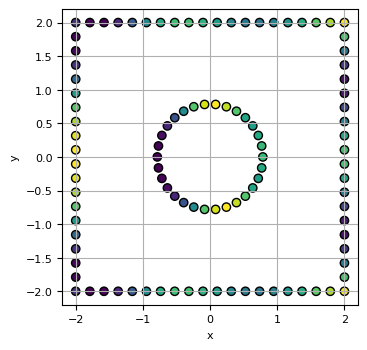

In [107]:
# Scatter plot: puntos coloreados por interiorPhi
plt.figure(figsize=(3.5, 3.5))
plt.scatter(points_outside[:, 0], points_outside[:, 1],
                 c=interiorPhi.real, cmap='viridis', edgecolors='k')
plt.scatter(aVertex[:, 0], aVertex[:, 1],
                 c=phi.real, cmap='viridis', edgecolors='k')
plt.gca().set_aspect('equal')
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()